# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR ID HERE ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [31]:
## my test
print(X_training.shape)
print(X_test.shape)

(2000, 2)
(1000, 2)


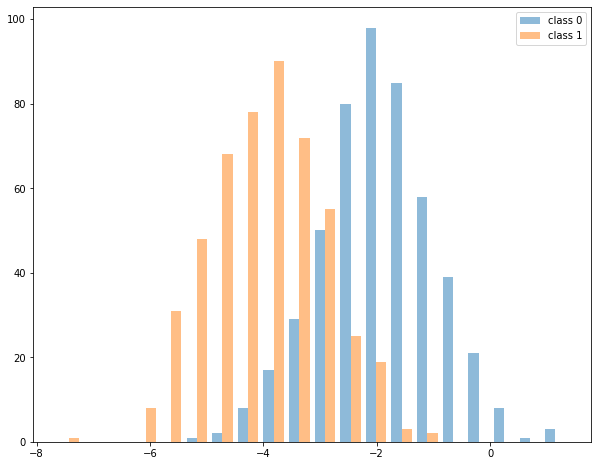

In [4]:
#### Your code here ####
#For the first feature only: (1)
first_1000 = training_set[:1000]
cls0_1000 = first_1000[first_1000['y'] == 0]['x1'].values
cls1_1000 = first_1000[first_1000['y'] == 1]['x1'].values
plt.hist([cls0_1000, cls1_1000], bins=20, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.show()

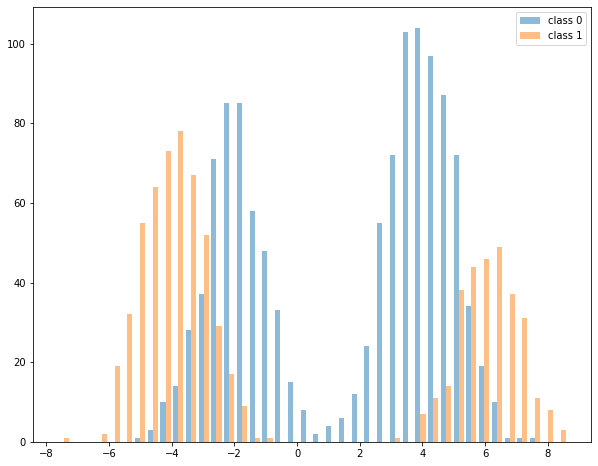

In [30]:
#For the first feature only: (2)
cls0_all = training_set[training_set['y'] == 0]['x1'].values
cls1_all = training_set[training_set['y'] == 1]['x1'].values
plt.hist([cls0_all, cls1_all], bins=40, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.show()

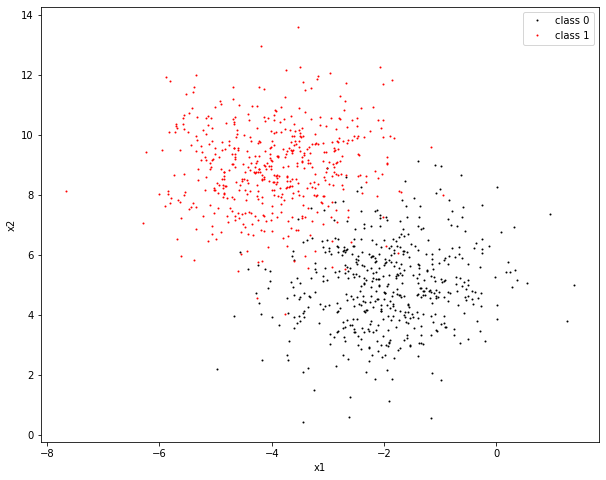

In [6]:
#For both features: (1)
# 1. For the first 1000 data points plot a scatter plot where each class has different color
first_1000_mat = training_set[:1000].values
cls0_mat_1000 = np.array([vec for vec in first_1000_mat if vec[2] == 0])
cls1_mat_1000 = np.array([vec for vec in first_1000_mat if vec[2] == 1])
plt.plot(cls0_mat_1000[:, 0], cls0_mat_1000[:, 1], 'ro', ms=1, mec='k')
plt.plot(cls1_mat_1000[:, 0], cls1_mat_1000[:, 1], 'ro', ms=1)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])
plt.show()

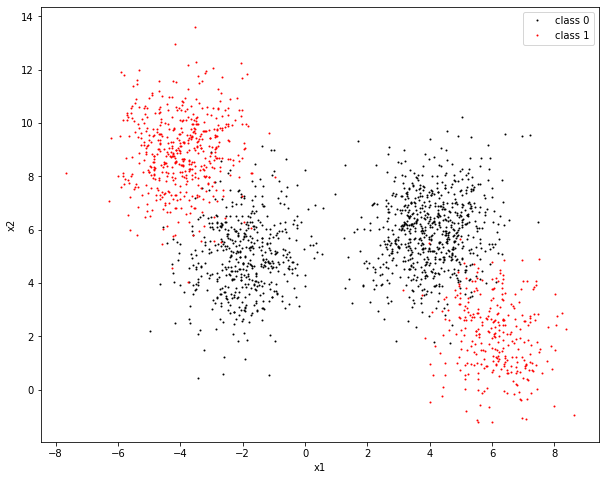

In [12]:
#For both features: (2)
# 2. For all the data points plot a scatter plot where each class has different color
all_mat = training_set.values
cls0_mat = np.array([vec for vec in all_mat if vec[2] == 0])
cls1_mat = np.array([vec for vec in all_mat if vec[2] == 1])
plt.plot(cls0_mat[:, 0], cls0_mat[:, 1], 'ro', ms=1, mec='k')
plt.plot(cls1_mat[:, 0], cls1_mat[:, 1], 'ro', ms=1)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [35]:
def compute_cost(X, y, theta):
    J = 0
    left_side = y * np.inner(X, theta)
    right_side = np.log(1 + (np.e ** np.inner(X, theta)))
    J = right_side - left_side
    return np.sum(J) / X.shape[0]

In [32]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, theta_shape, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = np.random.random(size=theta_shape)
        self.cost_list = []  # a list of the costs that you've calculated in each iteration

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
         # bias trick
        ones_col = np.ones(X.shape[0])
        X = np.column_stack((ones_col, X))
        
        J_history = []
        theta_copy = self.theta.copy()
        k = 0
        curr_cost = compute_cost(X, y, theta_copy)
        J_history.append(0)
        while (abs(curr_cost - J_history[len(J_history) - 1]) > self.eps) and (k < self.n_iter):
            if k == 0:
                J_history.pop()
            k += 1
            J_history.append(curr_cost)
            sigma = 1 / (1 + (np.e ** ((-1) * (np.inner(X, theta_copy)))))
            sigma -= y
            Xt_mult_vec = np.transpose(X).dot(sigma)
            Xt_mult_vec *= self.eta
            theta_copy = theta_copy - Xt_mult_vec
            curr_cost = compute_cost(X, y, theta_copy)
        self.theta = theta_copy
        self.cost_list = J_history
    
    def predict(self, X):
        """Return the predicted class label"""
        # bias trick
        if len(X.shape) > 1:
            ones_col = np.ones(X.shape[0])
            X = np.column_stack((ones_col, X))
        else:
            X = np.insert(X, 0, 1)

        sigma = [1 / (1 + (np.e ** ((-1) * (np.inner(self.theta, X)))))]
        return [1 if sig > 0.5 else 0 for sig in sigma]


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [10]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    exp = (((data - mu) / sigma) ** 2) / (-2)
    base_inv = sigma * ((2 * np.pi) ** 0.5)
    return (np.e ** exp) / base_inv

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [28]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.dim_gaussians_dict = {}
        self.responsibilities_dict = {}
        self.cost_list = []  # a list of the costs that you've calculated in each iteration

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params:
        """
        for dim in range(data.shape[1]):
            w_init = np.array([0 for _ in range(self.k)]) + (1 / self.k)
            cur_mu = data[:, dim].mean()
            cur_std = data[:, dim].std()
            rand_min_mu = cur_mu - (2 * cur_std)
            rand_max_mu = cur_mu + (2 * cur_std)
            mu_init = [np.random.uniform(rand_min_mu, rand_max_mu) for _ in range(self.k)]
            std_init = [np.random.uniform(0, 3) for _ in range(self.k)]
            self.dim_gaussians_dict[dim] = np.column_stack((w_init, mu_init, std_init))

    def compute_gmm_cost(self, data, dim):
        responsibilities_mat = np.array([norm_pdf(point, self.dim_gaussians_dict[dim][:, 1], self.dim_gaussians_dict[dim][:, 2]) for point in data[:, dim]])
        responsibilities_mat = responsibilities_mat * self.dim_gaussians_dict[dim][:, 0]
        responsibilities_mat = np.log(np.sum(responsibilities_mat, axis=1))
        return np.sum(responsibilities_mat) * (-1)

    def expectation(self, data, dim):
        """
        E step - calculating responsibilities
        """
        responsibilities_mat = np.array([norm_pdf(point, self.dim_gaussians_dict[dim][:, 1], self.dim_gaussians_dict[dim][:, 2]) for point in data[:, dim]])
        responsibilities_mat = responsibilities_mat * self.dim_gaussians_dict[dim][:, 0]
        responsibilities_vec_sum_axis1 = np.sum(responsibilities_mat, axis=1)
        self.responsibilities_dict[dim] = np.transpose((np.transpose(responsibilities_mat) / responsibilities_vec_sum_axis1))

    def maximization(self, data, dim):
        """
        M step - updating distribution params
        """
        # updating weights
        responsibilities_avg_vec = np.sum(self.responsibilities_dict[dim], axis=0)
        self.dim_gaussians_dict[dim][:, 0] = responsibilities_avg_vec / data.shape[0]

        # updating means
        mu_sum = np.sum(np.transpose((np.transpose(self.responsibilities_dict[dim])) * data[:, dim]), axis=0)
        self.dim_gaussians_dict[dim][:, 1] = mu_sum / responsibilities_avg_vec

        # updating stds
        x_i_columns = np.transpose(np.transpose(np.zeros_like(self.responsibilities_dict[dim])) + data[:, dim])
        std_sum = np.sum(self.responsibilities_dict[dim] * ((x_i_columns - self.dim_gaussians_dict[dim][:, 1]) ** 2), axis=0)
        self.dim_gaussians_dict[dim][:, 2] = ((std_sum / responsibilities_avg_vec) ** 0.5)

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        for dim in self.dim_gaussians_dict.keys():
            J_history = []
            k = 0
            curr_cost = self.compute_gmm_cost(data, dim)
            J_history.append(0)
            while (abs(curr_cost - J_history[len(J_history) - 1]) > self.eps) and (k < self.n_iter):
                if k == 0:
                    J_history.pop()
                k += 1
                J_history.append(curr_cost)
                self.expectation(data=data, dim=dim)
                self.maximization(data=data, dim=dim)
                curr_cost = self.compute_gmm_cost(data, dim)

    def get_dist_params(self):
        return self.dim_gaussians_dict

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [29]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1):
        self.k = k
        self.cls0_prior = 0
        self.cls1_prior = 0
        self.cls0_gaussians_dict = {}
        self.cls1_gaussians_dict = {}

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        # training classes partition
        dataset = np.column_stack((X, y))
        cls0 = np.array([vec for vec in dataset if vec[-1] == 0])
        cls1 = np.array([vec for vec in dataset if vec[-1] == 1])
        cls0 = cls0[:, 0:2]
        cls1 = cls1[:, 0:2]

        # get priors
        self.cls0_prior = cls0.shape[0] / dataset.shape[0]
        self.cls1_prior = cls1.shape[0] / dataset.shape[0]

        # get classes distribution parameters
        cls0_em = EM(self.k)
        cls1_em = EM(self.k)
        cls0_em.fit(cls0)
        cls1_em.fit(cls1)
        self.cls0_gaussians_dict = cls0_em.get_dist_params()
        self.cls1_gaussians_dict = cls1_em.get_dist_params()

    def get_likelihood(self, X, cls_gaussians_dict):
        dim_pdf_vec = []
        for dim in cls_gaussians_dict.keys():
            if len(X.shape) > 1:
                pdf_mat = np.array([norm_pdf(point, cls_gaussians_dict[dim][:, 1], cls_gaussians_dict[dim][:, 2]) for point in X[:, dim]])
            else:
                pdf_mat = np.array([norm_pdf(X, cls_gaussians_dict[dim][:, 1], cls_gaussians_dict[dim][:, 2])])
            pdf_mat = pdf_mat * cls_gaussians_dict[dim][:, 0]
            dim_pdf_vec.append(np.sum(pdf_mat, axis=1))
        return dim_pdf_vec[0] * dim_pdf_vec[1]

    def predict(self, X):
        """Return the predicted class label"""
        cls0_post = self.get_likelihood(X, self.cls0_gaussians_dict) * self.cls0_prior
        cls1_post = self.get_likelihood(X, self.cls1_gaussians_dict) * self.cls1_prior
        bool_ind_vec = cls1_post > cls0_post
        return np.where(bool_ind_vec==False, 0, bool_ind_vec)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [36]:
#### Your code here ####
# Model Evaluation
first1000_X_trainig = X_training[:1000]
first1000_y_training = y_training[:1000]
first500_X_test = X_test[:500]
first500_y_test = y_test[:500]

first1000_LoR = LogisticRegressionGD(theta_shape=3, eta=0.05, eps=1e-06)
first1000_LoR.fit(first1000_X_trainig, first1000_y_training)

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####
